# Working with highly imbalanced data

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import sklearn
sklearn.set_config(print_changed_only=True)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [17]:
# mammography dataset https://www.openml.org/d/310
data = pd.read_csv("data/mammography.csv")

In [18]:
target = data['class']

In [19]:
target.value_counts()

'-1'    10923
'1'       260
Name: class, dtype: int64

In [20]:
y = (target != "'-1'").astype(np.int)
y.value_counts()

0    10923
1      260
Name: class, dtype: int64

In [21]:
X = data.iloc[:, :-1]
X.shape

(11183, 6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f4f1790>,
      dtype=object)

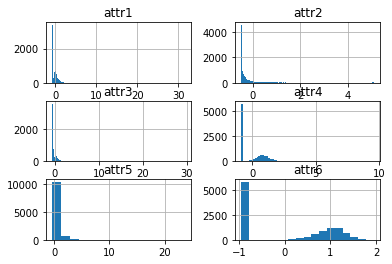

In [22]:
X.hist(bins='auto')

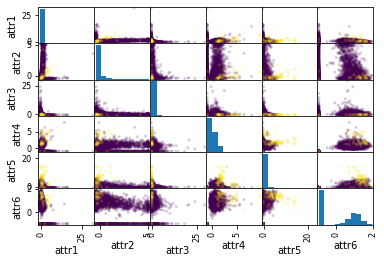

In [23]:
pd.plotting.scatter_matrix(X, c=y, alpha=.2);

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, stratify=y, random_state=0)

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9202523350276881, 0.6335760292641773)

In [26]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9396649182368051, 0.7351946384740741)

In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [28]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9198404861434387, 0.5616202754552766)

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [30]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9177019706865662, 0.5812015924535088)

In [31]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9510829019076773, 0.5844974828473378)

In [32]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9299056662920592, 0.7096221757763532)

# Class Weights

In [33]:
scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9190730343682848, 0.5815811057723485)

In [34]:
scores = cross_validate(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9227509282900812, 0.6964458286311985)

# Resampled Ensembles

In [35]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
resampled_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)

In [36]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9495292013648882, 0.6490784973162692)

In [37]:
GridSearchCV(scoring=('roc_auc', 'average_precision'), refit='average_precision')

NameError: name 'GridSearchCV' is not defined

In [ ]:
GridSearchCV(scoring=('roc_auc', 'average_precision'), refit=False)

# Exercise
Pick two or three of the models and strategies above, run grid-search (optimizing roc_auc or average precision), and
plot the roc curves and PR-curves for these models.